In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install open3d

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 3.4 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.8
    Uninstalling widgetsnbextension-3.6.8:
      Successfully uninstalled widgetsnbextension-3.6.8
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 732.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.1 MB/s eta 0:00:00


In [ ]:
import open3d as o3d
import numpy as np
import os, cv2

images_data, pc_data, m_depth_data, normals, triangles_, color = [], [], [], [], [], []
clouds_dir = sorted(os.listdir('/content/drive/MyDrive/Mesh Generated Data/Meshs 3D'))
images_dir = sorted(os.listdir('/content/drive/MyDrive/Mesh Generated Data/Fastener Images'))
m_depth_dir = sorted(os.listdir('/content/drive/MyDrive/Mesh Generated Data/Monocular Depth'))

for PC, iimage, M_Depth in zip(clouds_dir, images_dir, m_depth_dir):
  image = cv2.imread(f'/content/drive/MyDrive/Mesh Generated Data/Fastener Images/{iimage}')
  image = cv2.resize(image, (256, 256))
  image = (image-image.min())/(image.max()-image.min())
  m_depth = cv2.imread(f'/content/drive/MyDrive/Mesh Generated Data/Monocular Depth/{M_Depth}')
  m_depth = cv2.resize(m_depth, (256, 256))
  m_depth = (m_depth-m_depth.min())/(m_depth.max()-m_depth.min())
  mesh = o3d.io.read_triangle_mesh(f'/content/drive/MyDrive/Mesh Generated Data/Meshs 3D/{PC}')
  vertices = o3d.utility.Vector3dVector(mesh.vertices)
  vertices_array = np.asarray(vertices)
  images_data.append(image)
  pc_data.append(vertices_array)
  mesh.compute_vertex_normals()
  # Access the computed vertex normals
  NORM = np.asarray(mesh.vertex_normals)
  normals.append(NORM)
  TRI = np.asarray(mesh.triangles)
  triangles_.append(TRI)
  colors = np.array(mesh.vertex_colors)
  color.append(colors)
  m_depth_data.append(m_depth)

def pad_point_clouds(point_clouds):
    # Find the maximum number of points among all point clouds
    max_num_points = max(len(pc) for pc in point_clouds)
    padded_point_clouds = []
    # Pad each point cloud to the maximum size
    for pc in point_clouds:
        num_points_to_pad = max_num_points - len(pc)
        padded_pc = np.pad(pc, ((0, num_points_to_pad), (0, 0)), mode='constant', constant_values=0)
        padded_point_clouds.append(padded_pc)
    return padded_point_clouds

pc_data = pad_point_clouds(pc_data)
normal_data = pad_point_clouds(normals)
triangle_data = pad_point_clouds(triangles_)
color_data = pad_point_clouds(color)

MESHEs = np.array(pc_data)
NORMALs = np.array(normal_data)
TRIANGLEs = np.array(triangle_data)
COLORs = np.array(color_data)
IMAGEs = np.array(images_data)
M_DEPTHs = np.array(m_depth_data)

MESHEs.shape, NORMALs.shape, TRIANGLEs.shape, COLORs.shape, IMAGEs.shape, M_DEPTHs.shape

((29, 25056, 3),
 (29, 25056, 3),
 (29, 49948, 3),
 (29, 25056, 3),
 (29, 256, 256, 3),
 (29, 256, 256, 3))

In [ ]:
import torch
import torch.nn.functional as F
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

In [ ]:
def create_edge_index(triangles):
    edge_index = []
    for tri in triangles:
        edge_index.append([tri[0], tri[1]])
        edge_index.append([tri[1], tri[2]])
        edge_index.append([tri[2], tri[0]])
    return torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# Convert all tensors to float32
MESHEs = torch.tensor(MESHEs, dtype=torch.float32)
NORMALs = torch.tensor(NORMALs, dtype=torch.float32)
COLORs = torch.tensor(COLORs, dtype=torch.float32)
TRIANGLEs = torch.tensor(TRIANGLEs, dtype=torch.long)

# Combine features
features = torch.cat([MESHEs, NORMALs, COLORs], dim=-1)

# Create edge index for each mesh
edge_indices = [create_edge_index(tri) for tri in TRIANGLEs]

# Create PyG Data objects
data_list = []
for i in range(len(MESHEs)):
    data = Data(x=features[i], edge_index=edge_indices[i])
    data_list.append(data)

# Example data object
print(data_list[0])


Data(x=[25056, 9], edge_index=[2, 149844])


In [ ]:
class MeshGNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MeshGNN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

input_dim = features.shape[-1]
hidden_dim = 16
output_dim = 32
GNNmodel = MeshGNN(input_dim, hidden_dim, output_dim)
GNNmodel

MeshGNN(
  (conv1): GCNConv(9, 16)
  (conv2): GCNConv(16, 32)
)

In [ ]:
data_list[0]

In [ ]:
import torch.optim as optim
from torch_geometric.loader import DataLoader

# Create DataLoader
train_loader = DataLoader(data_list, batch_size=1)
mesh_loader = DataLoader(MESHEs, batch_size=1)

# Optimizer
optimizer = optim.Adam(GNNmodel.parameters(), lr=0.01)

In [ ]:
mesh_loader.dataset[0]

tensor([[-0.2208, -0.0974, -0.7518],
        [-0.2217, -0.0961, -0.7513],
        [-0.2189, -0.0972, -0.7519],
        ...,
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000]])

In [ ]:
for data in train_loader:
  out = GNNmodel(data_list[0])
  print(out)
  break

tensor([[ 0.1093, -0.2894, -0.2012,  ...,  0.0288, -0.0521, -0.1704],
        [ 0.1094, -0.2891, -0.2013,  ...,  0.0287, -0.0522, -0.1706],
        [ 0.1090, -0.2894, -0.2011,  ...,  0.0286, -0.0520, -0.1702],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       grad_fn=<AddBackward0>)


In [ ]:
# Training loop
def train():
    model.train()
    for data in train_loader:
        optimizer.zero_grad()
        out = model(data)
        loss = F.mse_loss(out, data.x)  # Example loss function
        loss.backward()
        optimizer.step()

# Example training for 10 epochs
for epoch in range(10):
    train()

# Inference
model.eval()
with torch.no_grad():
    for data in data_list:
        out = model(data)
        print(out.shape)  # Representation of the mesh

RuntimeError: expected m1 and m2 to have the same dtype, but got: double != float

In [ ]:
np.array(edge_indices).shape

(29, 2, 149844)

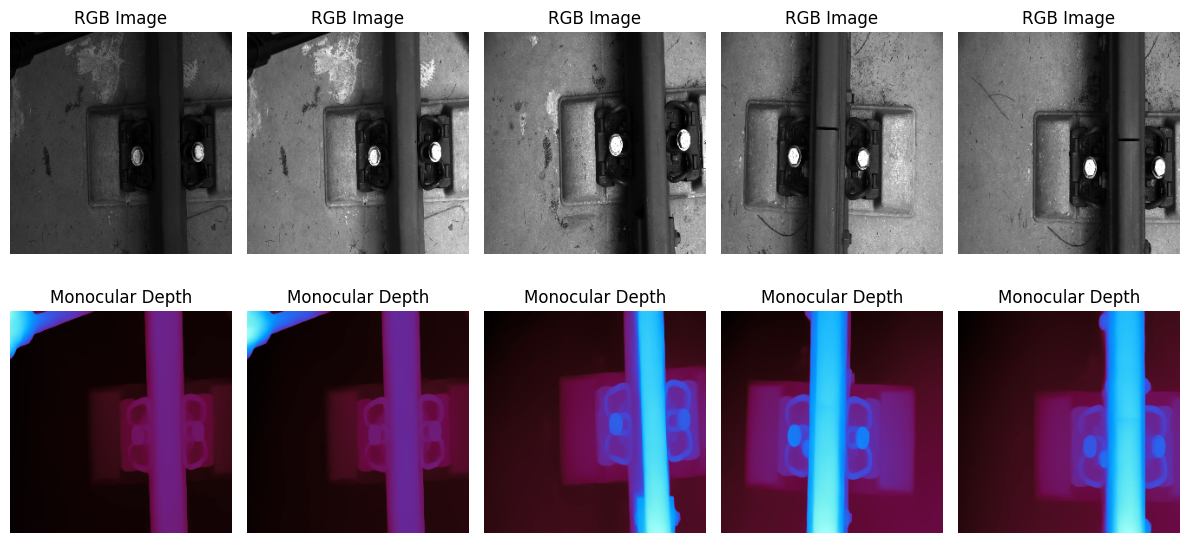

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 5, figsize=(12, 6))

# Turn off axis labels and ticks
for ax in axs.flatten():
    ax.axis('off')

# Plot the images
for i in range(5):
    axs[0, i].imshow(IMAGEs[i])
    axs[0, i].set_title('RGB Image')
    axs[1, i].imshow(M_DEPTHs[i])
    axs[1, i].set_title('Monocular Depth')

# Show the plot
plt.tight_layout()
plt.show()

# **Image & Depth Mode**

In [ ]:
import os
import keras
from keras import layers
from matplotlib import pyplot as plt
import tensorflow as tf
keras.utils.set_random_seed(seed=42)

In [ ]:
class Involution(keras.layers.Layer):
    def __init__(self, channel, group_number, kernel_size, stride, reduction_ratio, name):
        super().__init__(name=name)
        # Initialize the parameters.
        self.channel = channel
        self.group_number = group_number
        self.kernel_size = kernel_size
        self.stride = stride
        self.reduction_ratio = reduction_ratio

    def build(self, input_shape):
        # Get the shape of the input.
        (_, height, width, num_channels) = input_shape
        # Scale the height and width with respect to the strides.
        height = height // self.stride
        width = width // self.stride
        # Define a layer that average pools the input tensor
        # if stride is more than 1.
        self.stride_layer = (
            keras.layers.AveragePooling2D(
                pool_size=self.stride, strides=self.stride, padding="same"
            )
            if self.stride > 1
            else tf.identity
        )
        # Define the kernel generation layer.
        self.kernel_gen = keras.Sequential(
            [
                keras.layers.Conv2D(
                    filters=self.channel // self.reduction_ratio, kernel_size=1
                ),
                keras.layers.BatchNormalization(),
                keras.layers.ReLU(),
                keras.layers.Conv2D(
                    filters=self.kernel_size * self.kernel_size * self.group_number,
                    kernel_size=1,
                ),
            ]
        )
        # Define reshape layers
        self.kernel_reshape = keras.layers.Reshape(
            target_shape=(
                height,
                width,
                self.kernel_size * self.kernel_size,
                1,
                self.group_number,
            )
        )
        self.input_patches_reshape = keras.layers.Reshape(
            target_shape=(
                height,
                width,
                self.kernel_size * self.kernel_size,
                num_channels // self.group_number,
                self.group_number,
            )
        )
        self.output_reshape = keras.layers.Reshape(
            target_shape=(height, width, num_channels)
        )

    def call(self, x):
        # Generate the kernel with respect to the input tensor.
        # B, H, W, K*K*G
        kernel_input = self.stride_layer(x)
        kernel = self.kernel_gen(kernel_input)

        # reshape the kerenl
        # B, H, W, K*K, 1, G
        kernel = self.kernel_reshape(kernel)

        # Extract input patches.
        # B, H, W, K*K*C
        input_patches = tf.image.extract_patches(
            images=x,
            sizes=[1, self.kernel_size, self.kernel_size, 1],
            strides=[1, self.stride, self.stride, 1],
            rates=[1, 1, 1, 1],
            padding="SAME",
        )

        # Reshape the input patches to align with later operations.
        # B, H, W, K*K, C//G, G
        input_patches = self.input_patches_reshape(input_patches)
        # Compute the multiply-add operation of kernels and patches.
        # B, H, W, K*K, C//G, G
        output = tf.multiply(kernel, input_patches)
        # B, H, W, C//G, G
        output = tf.reduce_sum(output, axis=3)
        # Reshape the output kernel.
        # B, H, W, C
        output = self.output_reshape(output)
        # Return the output tensor and the kernel.
        return output, kernel

In [ ]:
output_tensor, _ = Involution(
    channel=3, group_number=1, kernel_size=5, stride=1, reduction_ratio=1, name="inv_1"
)(tf.random.uniform((1, 128, 128, 3)))

In [ ]:
def window_partition(x, window_size):
    _, height, width, channels = x.shape
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        x,
        (
            -1,
            patch_num_y,
            window_size,
            patch_num_x,
            window_size,
            channels,
        ),
    )
    x = tf.transpose(x, (0, 1, 3, 2, 4, 5))
    windows = tf.reshape(x, (-1, window_size, window_size, channels))
    return windows


def window_reverse(windows, window_size, height, width, channels):
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        windows,
        (
            -1,
            patch_num_y,
            patch_num_x,
            window_size,
            window_size,
            channels,
        ),
    )
    x = tf.transpose(x, (0, 1, 3, 2, 4, 5))
    x = tf.reshape(x, (-1, height, width, channels))
    return x

# **PointNet Model**

In [ ]:
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras import optimizers, losses
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return K.sum(self.l2reg * tf.square(xxt - self.eye))

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras import optimizers, losses

class RadialBasisFunction(layers.Layer):
    def __init__(self, grid_min, grid_max, num_grids, **kwargs):
        super(RadialBasisFunction, self).__init__(**kwargs)
        self.grid = tf.cast(
            tf.linspace(grid_min, grid_max, num_grids),dtype=tf.float32)
        self.denominator = tf.cast((grid_max - grid_min) / num_grids,dtype=tf.float32,)
    def call(self, x):
        return tf.exp(-((x[..., None] - self.grid) / self.denominator) ** 2)

class FastKANLayer(layers.Layer):
    def __init__(self, input_dim, num_features, grid_min, grid_max, num_grids, use_base_update, base_activation, spline_weight_init_scale):
        super(FastKANLayer, self).__init__()
        bias = keras.initializers.Constant(np.eye(num_features).flatten())
        reg = OrthogonalRegularizer(num_features)
        self.norm = layers.LayerNormalization(axis=-1)
        self.rbf = RadialBasisFunction(grid_min, grid_max, num_grids)
        self.spline_linear = layers.Dense(num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,)
        self.use_base_update = use_base_update
        if use_base_update:
            self.base_activation = base_activation
            self.base_linear = layers.Dense(num_features*num_features, kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,)
    def call(self, x):
        x_norm = self.norm(x)
        spline_basis = self.rbf(x_norm)
        spline_basis_flat = tf.reshape(spline_basis, [tf.shape(spline_basis)[0], -1])
        ret = self.spline_linear(spline_basis_flat)
        if self.use_base_update:
            base = self.base_linear(self.base_activation(x))
            ret = ret + base
        return ret
class FastKAN(tf.keras.Model):
    def __init__(self, layers_hidden, grid_min=-1, grid_max=1, num_grids=10, use_base_update=False, base_activation='relu', spline_weight_init_scale=1):
        super(FastKAN, self).__init__()
        self.layers_list = []
        for in_dim, out_dim in zip(layers_hidden[:-1], layers_hidden[1:]):
            self.layers_list.append(FastKANLayer(in_dim, out_dim, grid_min, grid_max, num_grids, use_base_update, base_activation, spline_weight_init_scale))

    def call(self, inputs):
        x = inputs
        for layer in self.layers_list:
            x = layer(x)
        return x

# Define model
KAN_Model = FastKAN([None, 32, 3])
Input = keras.layers.Input(shape=(64, 3))
x = KAN_Model(Input)
KaN = keras.Model(inputs=Input, outputs=x, name="pointnet")
# model.summary()
KaN(tf.random.uniform((1, 64, 3)))

ValueError: Exception encountered when calling layer "fast_kan_23" (type FastKAN).

in user code:

    File "<ipython-input-22-119946042c68>", line 52, in call  *
        x = layer(x)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/tmp/__autograph_generated_filel0a9v47l.py", line 13, in tf__call
        ret = ag__.converted_call(ag__.ld(self).spline_linear, (ag__.ld(spline_basis_flat),), None, fscope)

    ValueError: Exception encountered when calling layer 'fast_kan_layer_45' (type FastKANLayer).
    
    in user code:
    
        File "<ipython-input-22-119946042c68>", line 37, in call  *
            ret = self.spline_linear(spline_basis_flat)
        File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
        File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py", line 148, in build
            raise ValueError(
    
        ValueError: The last dimension of the inputs to a Dense layer should be defined. Found None. Full input shape received: (None, None)
    
    
    Call arguments received by layer 'fast_kan_layer_45' (type FastKANLayer):
      • x=tf.Tensor(shape=(None, 64, 3), dtype=float32)


Call arguments received by layer "fast_kan_23" (type FastKAN):
  • inputs=tf.Tensor(shape=(None, 64, 3), dtype=float32)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, initializers, regularizers
import numpy as np

class RadialBasisFunction(layers.Layer):
    def __init__(self, grid_min, grid_max, num_grids, **kwargs):
        super(RadialBasisFunction, self).__init__(**kwargs)
        self.grid = tf.cast(tf.linspace(grid_min, grid_max, num_grids), dtype=tf.float32)
        self.denominator = tf.cast((grid_max - grid_min) / num_grids, dtype=tf.float32)

    def call(self, x):
        return tf.exp(-((x[..., None] - self.grid) / self.denominator) ** 2)

class FastKANLayer(layers.Layer):
    def __init__(self, num_features, grid_min, grid_max, num_grids, use_base_update, base_activation, spline_weight_init_scale):
        super(FastKANLayer, self).__init__()
        bias = initializers.Constant(np.eye(num_features).flatten())
        reg = OrthogonalRegularizer(num_features)
        self.norm = layers.LayerNormalization(axis=-1)
        self.rbf = RadialBasisFunction(grid_min, grid_max, num_grids)
        self.spline_linear = layers.Dense(num_features * num_features,
                                          kernel_initializer="zeros",
                                          bias_initializer=bias,
                                          activity_regularizer=reg)
        self.use_base_update = use_base_update
        if use_base_update:
            self.base_activation = layers.Activation(base_activation)
            self.base_linear = layers.Dense(num_features * num_features,
                                            kernel_initializer="zeros",
                                            bias_initializer=bias,
                                            activity_regularizer=reg)

    def call(self, x):
        x_norm = self.norm(x)
        spline_basis = self.rbf(x_norm)
        spline_basis_flat = tf.reshape(spline_basis, [tf.shape(spline_basis)[0], tf.shape(spline_basis)[1] * tf.shape(spline_basis)[2]])
        ret = self.spline_linear(spline_basis_flat)
        if self.use_base_update:
            base = self.base_linear(self.base_activation(x))
            ret = ret + base
        return ret

def create_fastkan_model(input_shape, layers_hidden, grid_min=-1, grid_max=1, num_grids=10, use_base_update=False, base_activation='relu', spline_weight_init_scale=1):
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs
    for in_dim, out_dim in zip(layers_hidden[:-1], layers_hidden[1:]):
        x = FastKANLayer(out_dim, grid_min, grid_max, num_grids, use_base_update, base_activation, spline_weight_init_scale)(x)
    outputs = x
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Example usage
input_shape = (64, 3)
layers_hidden = [32, 64]
KANNN = create_fastkan_model(input_shape, layers_hidden, grid_min=-1, grid_max=1, num_grids=10, use_base_update=False, base_activation='relu', spline_weight_init_scale=1)
KANNN.compile(optimizer='adam', loss='mse')
KANNN.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 3)]           0         
                                                                 
 fast_kan_layer_2 (FastKANL  (None, 4096)              790534    
 ayer)                                                           
                                                                 
Total params: 790534 (3.02 MB)
Trainable params: 790534 (3.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)

In [ ]:
def tnet(inputs, num_features):
    # Initialise bias as the identity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)
    x = conv_bn(inputs, 32)
    x = conv_bn(x, 4)
    x = conv_bn(x, 3)
    KAN_Model = create_fastkan_model((25056, 3), [32, 3], grid_min=-1, grid_max=1, num_grids=10,
                                     use_base_update=False, base_activation='relu', spline_weight_init_scale=1)
    x = KAN_Model(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

In [ ]:
75168/3

25056.0

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, initializers, regularizers
import numpy as np

class RadialBasisFunction2(layers.Layer):
    def __init__(self, grid_min, grid_max, num_grids, **kwargs):
        super(RadialBasisFunction2, self).__init__(**kwargs)
        self.grid = tf.cast(tf.linspace(grid_min, grid_max, num_grids), dtype=tf.float32)
        self.denominator = tf.cast((grid_max - grid_min) / num_grids, dtype=tf.float32)

    def call(self, x):
        return tf.exp(-((x[..., None] - self.grid) / self.denominator) ** 2)

class FastKANLayerG(layers.Layer):
    def __init__(self, num_features, grid_min, grid_max, num_grids, use_base_update, base_activation, spline_weight_init_scale):
        super(FastKANLayerG, self).__init__()
        bias = initializers.Constant(np.eye(num_features).flatten())
        reg = OrthogonalRegularizer(num_features)
        self.norm = layers.LayerNormalization(axis=-1)
        self.rbf = RadialBasisFunction2(grid_min, grid_max, num_grids)
        self.spline_linear = layers.Dense(num_features * num_features)
        self.use_base_update = use_base_update
        if use_base_update:
            self.base_activation = layers.Activation(base_activation)
            self.base_linear = layers.Dense(num_features * num_features)

    def call(self, x):
        x_norm = self.norm(x)
        spline_basis = self.rbf(x_norm)
        spline_basis_flat = tf.reshape(spline_basis, [tf.shape(spline_basis)[0], tf.shape(spline_basis)[1] * tf.shape(spline_basis)[2]])
        ret = self.spline_linear(spline_basis_flat)
        if self.use_base_update:
            base = self.base_linear(self.base_activation(x))
            ret = ret + base
        return ret

def create_fastkan_modelG(input_shape, layers_hidden, grid_min=-1, grid_max=1, num_grids=10, use_base_update=False, base_activation='relu', spline_weight_init_scale=1):
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs
    for in_dim, out_dim in zip(layers_hidden[:-1], layers_hidden[1:]):
        x = FastKANLayerG(out_dim, grid_min, grid_max, num_grids, use_base_update, base_activation, spline_weight_init_scale)(x)
    outputs = x
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

# Example usage
input_shape = (64, 3)
layers_hidden = [32, 64]
KAN_GeneraL = create_fastkan_modelG(input_shape, layers_hidden, grid_min=-1, grid_max=1, num_grids=10, use_base_update=False, base_activation='relu', spline_weight_init_scale=1)
KAN_GeneraL.compile(optimizer='adam', loss='mse')
KAN_GeneraL.summary()


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 64, 3)]           0         
                                                                 
 fast_kan_layer_g (FastKANL  (None, 4096)              790534    
 ayerG)                                                          
                                                                 
Total params: 790534 (3.02 MB)
Trainable params: 790534 (3.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
inputs = keras.Input(shape=(25056, 3))
ALL = keras.Input(shape=(25056, 9))
x = tnet(inputs, 3)
x = GNNmodel(ALL)
kan_general1 = create_fastkan_modelG(input_shape, layers_hidden, grid_min=-1, grid_max=1, num_grids=10, use_base_update=False, base_activation='relu', spline_weight_init_scale=1)
x = kan_general1(x)
x = layers.Dropout(0.3)(x)
kan_general2 = create_fastkan_modelG(input_shape, layers_hidden, grid_min=-1, grid_max=1, num_grids=10, use_base_update=False, base_activation='relu', spline_weight_init_scale=1)
outputs = kan_general2(x)
model = keras.Model(inputs=[inputs, ALL], outputs=outputs, name="pointnet")
model.summary()

ValueError: Exception encountered when calling layer 'fast_kan_layer_1' (type FastKANLayer).

in user code:

    File "<ipython-input-5-fb374673542a>", line 37, in call  *
        ret = self.spline_linear(spline_basis_flat)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 280, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "dense" is incompatible with the layer: expected axis -1 of input shape to have value 192, but received input with shape (None, 75168)


Call arguments received by layer 'fast_kan_layer_1' (type FastKANLayer):
  • x=tf.Tensor(shape=(None, 25056, 3), dtype=float32)

# **SWIN Transformer**

# **Self-Supervised**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

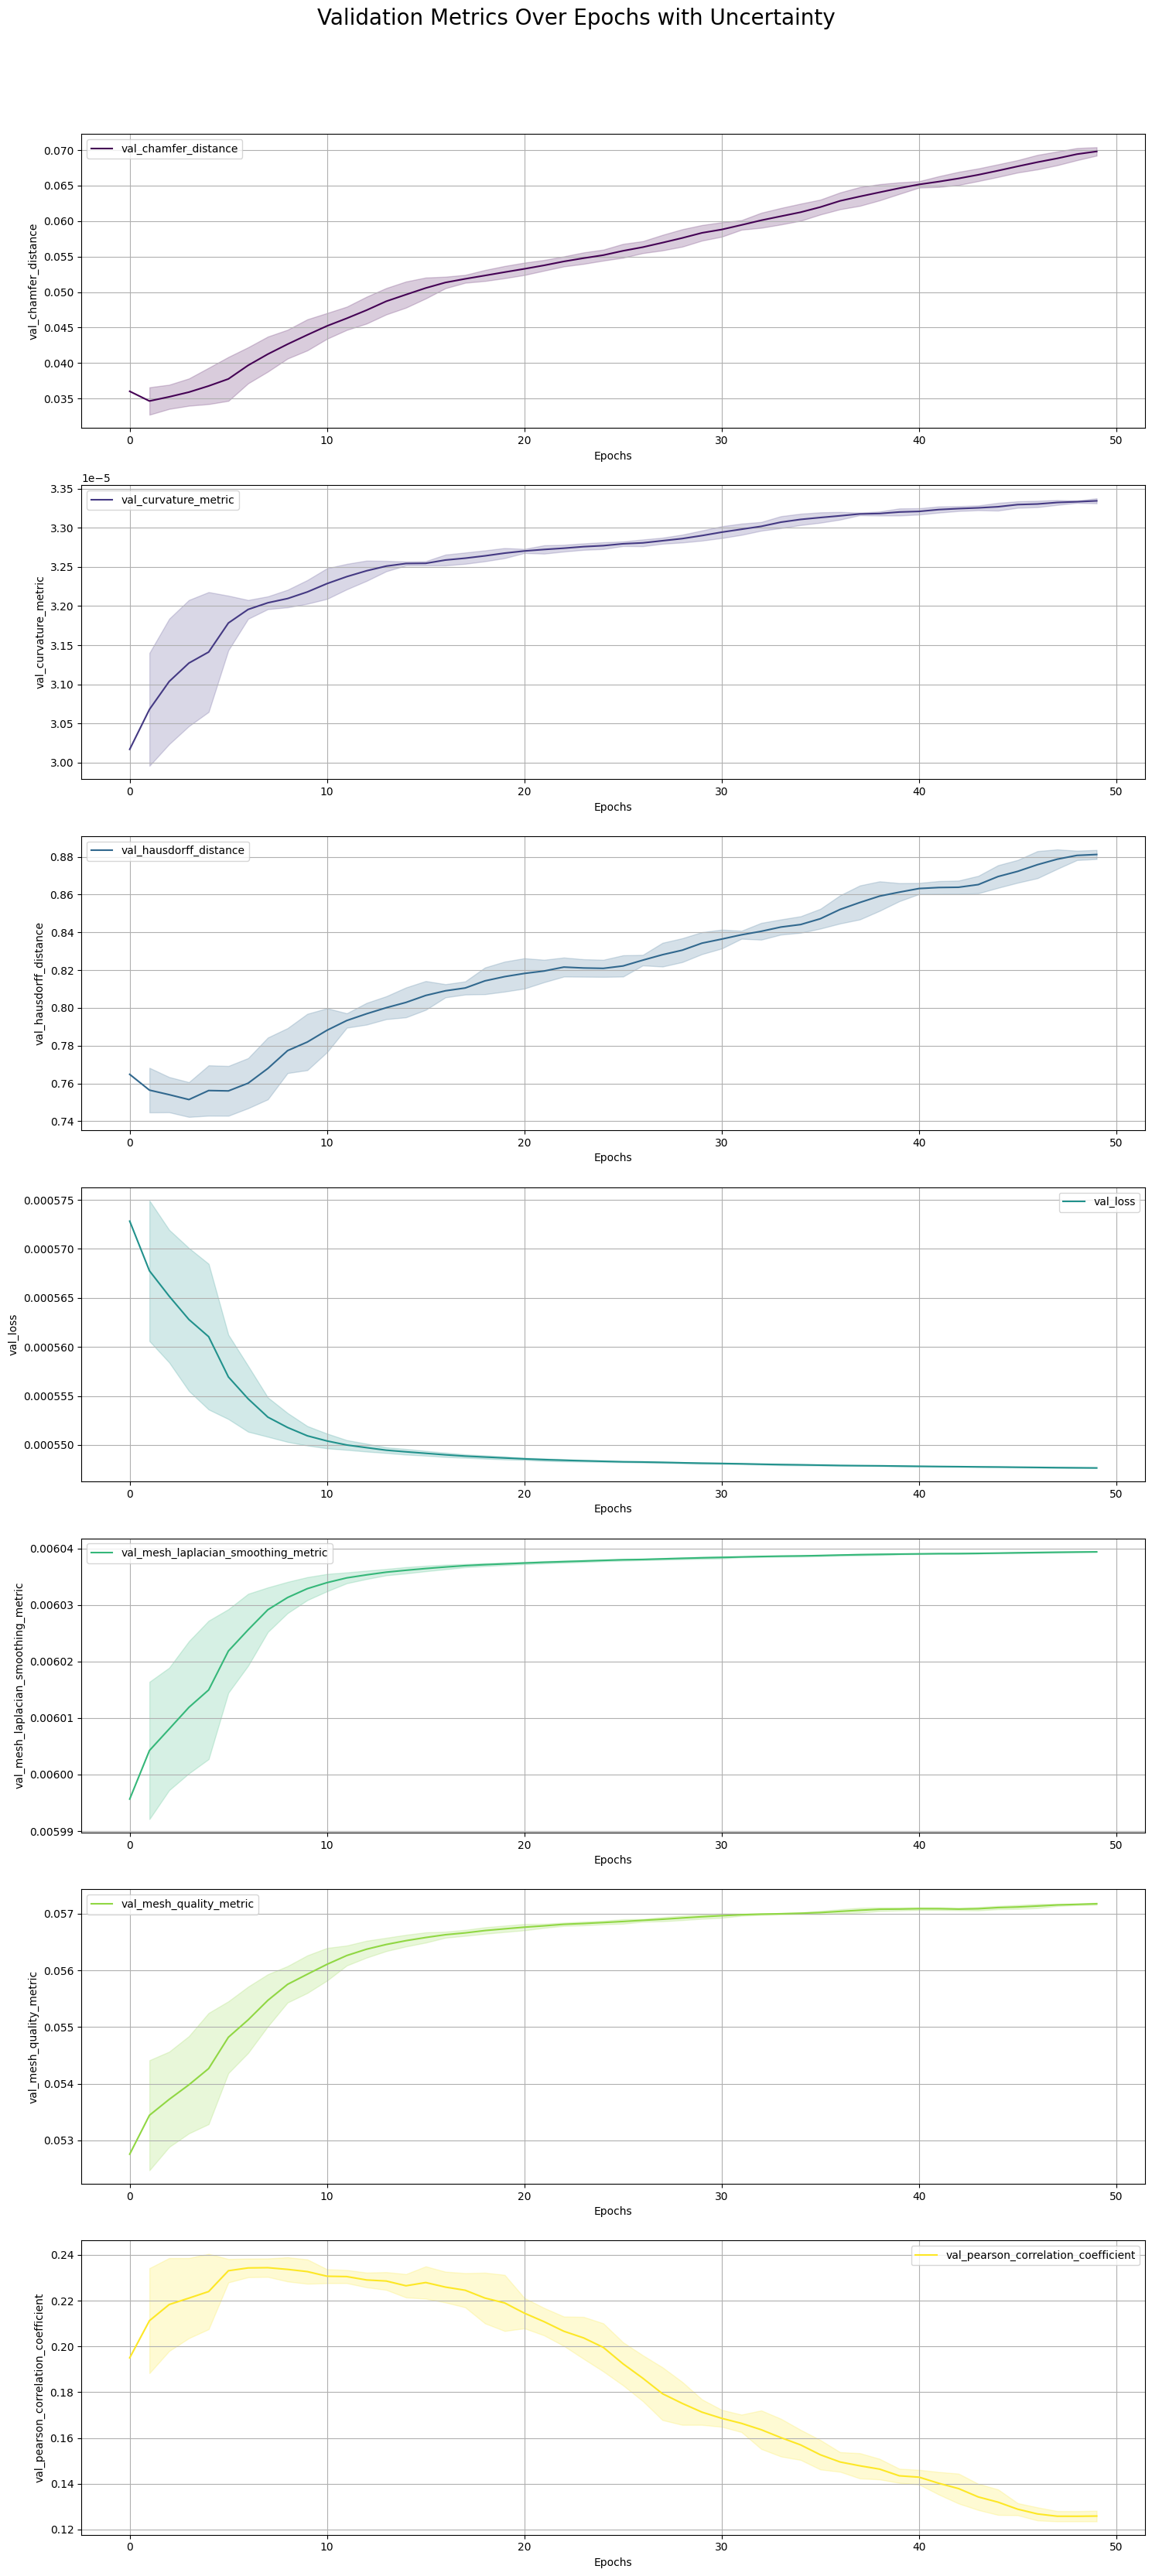

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the CSV file
file_path = '/content/Mesh_Autoencoder(surface_normal_loss).csv'
data = pd.read_csv(file_path)

# Extract epochs and validation metrics
epochs = data['epoch']
val_metrics = [
    'val_chamfer_distance', 'val_curvature_metric', 'val_hausdorff_distance',
    'val_loss', 'val_mesh_laplacian_smoothing_metric', 'val_mesh_quality_metric',
    'val_pearson_correlation_coefficient'
]

# Create subplots
fig, axes = plt.subplots(len(val_metrics), 1, figsize=(15, len(val_metrics) * 5))
fig.suptitle('Validation Metrics Over Epochs with Uncertainty', fontsize=20)

# Plot each validation metric with uncertainty
colors = plt.cm.viridis(np.linspace(0, 1, len(val_metrics)))

for i, metric in enumerate(val_metrics):
    ax = axes[i]
    values = data[metric]
    mean = values.rolling(window=5, min_periods=1).mean()
    std = values.rolling(window=5, min_periods=1).std()
    ax.plot(epochs, mean, label=metric, color=colors[i])
    ax.fill_between(epochs, mean - std, mean + std, color=colors[i], alpha=0.2)
    ax.set_xlabel('Epochs')
    ax.set_ylabel(metric)
    ax.legend()
    ax.grid(True)

# Adjust layout and save the figure
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig_path = 'Metrics_Over_Epochs_with_Uncertainty.png'
plt.savefig(fig_path, dpi=300)
plt.show()


In [ ]:
# Load the CSV file
file_path = '/content/Mesh_Autoencoder(edge_length_loss).csv'
data = pd.read_csv(file_path)

In [ ]:
data.columns = ['Epoch', 'Chamfer Distance', '  Curvature Metric', 'Hausdorff Distance',
       'Loss', 'Mesh Laplacian Smoothing Metric', 'Mesh Quality Metric',
       'Pearson Correlation Coefficient', 'Val Chamfer Metric',
       'Val Curvature Metric', 'Val Hausdorff Distance', 'Val Edge Length Loss',
       'Val Mesh Laplacian Smoothing Metric', 'Val Mesh Quality Metric', 'Val Pearson Correlation Coefficient']

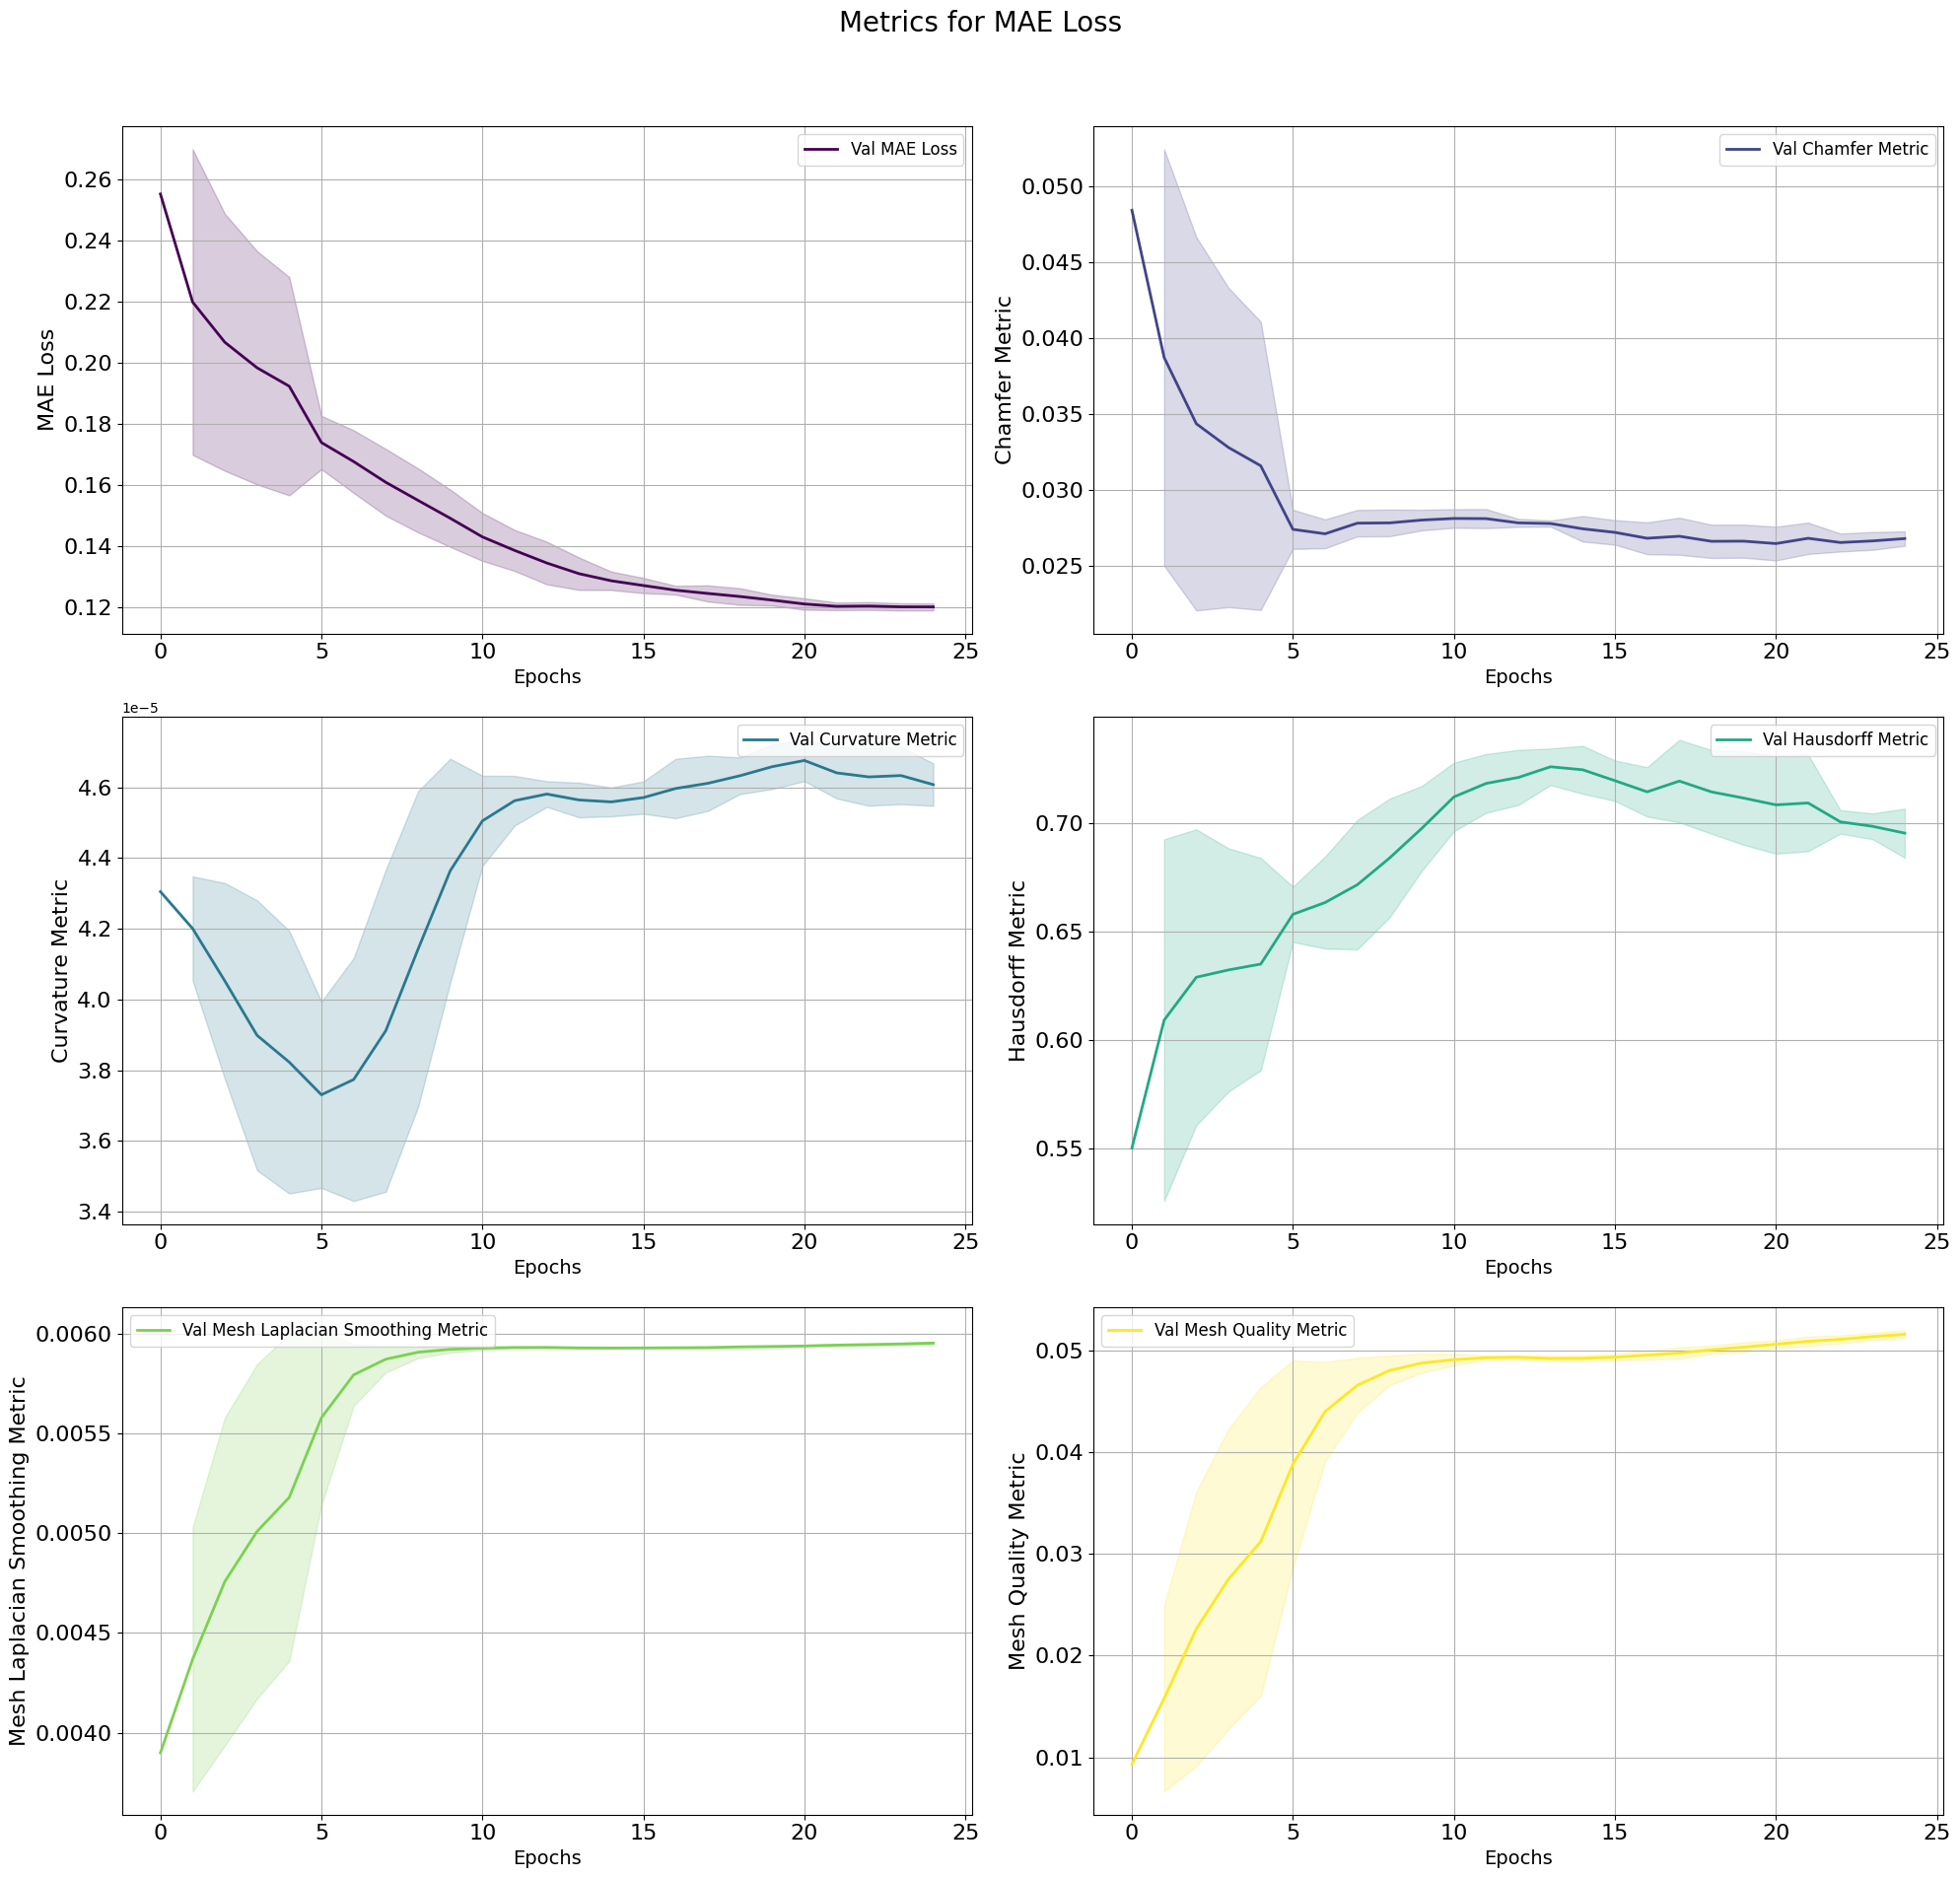

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

file_path = '/content/Mesh_Autoencoder(mae_metric).csv'
data = pd.read_csv(file_path)
data.drop(columns = ['val_pearson_correlation_coefficient', 'pearson_correlation_coefficient'], inplace=True)

data.columns = ['Epoch', 'Chamfer Distance', 'Curvature Metric', 'Hausdorff Distance',
       'Loss', 'Mesh Laplacian Smoothing Metric', 'Mesh Quality Metric',
        'Val Chamfer Metric',
       'Val Curvature Metric', 'Val Hausdorff Metric', 'Val MAE Loss',
       'Val Mesh Laplacian Smoothing Metric', 'Val Mesh Quality Metric']
# Extract epochs and validation metrics
epochs = data['Epoch']

# Extract epochs and validation metrics
epochs = data['Epoch']
val_metrics = [
    'Val MAE Loss', 'Val Chamfer Metric',
       'Val Curvature Metric', 'Val Hausdorff Metric',
       'Val Mesh Laplacian Smoothing Metric', 'Val Mesh Quality Metric'
]

Mats = [
    'MAE Loss', 'Chamfer Metric', 'Curvature Metric',
    'Hausdorff Metric', 'Mesh Laplacian Smoothing Metric',
    'Mesh Quality Metric'
]

# Create subplots with 3x2 grid
fig, axes = plt.subplots(3, 2, figsize=(20, 20))
fig.suptitle('Metrics for MAE Loss', fontsize=20)

# Plot each validation metric with uncertainty
colors = plt.cm.viridis(np.linspace(0, 1, len(val_metrics)))
axes = axes.flatten()

for i, (metric, matss) in enumerate(zip(val_metrics, Mats)):
    ax = axes[i]
    values = data[metric]
    mean = values.rolling(window=5, min_periods=1).mean()
    std = values.rolling(window=5, min_periods=1).std()
    ax.plot(epochs, mean, label=metric, color=colors[i], linewidth=2)
    ax.fill_between(epochs, mean - std, mean + std, color=colors[i], alpha=0.2)
    ax.set_xlabel('Epochs', fontsize=14)
    ax.set_ylabel(matss, fontsize=16)
    ax.legend(fontsize=12)
    ax.grid(True)
    ax.tick_params(axis='both', which='major', labelsize=16)

# Adjust layout and save the figure
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig_path = 'MAE_Loss.png'
plt.savefig(fig_path, dpi=300)
plt.show()
